# Preamble

In [1]:
import h5py
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import corner
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import bounded_3d_kde as bounded_3d_kde
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

seed = 102312328

In [2]:
def read_DCO(var = 'v02.35.02/N1e7_Fiducial_AllDCO_AIS/',
             rate_key = 'Rates_mu00.025_muz-0.049_alpha-1.79_sigma01.129_sigmaz0.048_a0.017_b1.487_c4.442_d5.886_zBinned', 
             redshift_interest  = 0.2):
    
    ####################################
    data_dir = '/mnt/ceph/users/lvanson/CompasOutput/' + var

    # Read the rates data
    RateFile = h5py.File(data_dir+'/CosmicIntegration/Rate_info.h5', 'r')    

    # Print the keys in the simulation data
    print(RateFile[rate_key].keys())

    # Print the shape of each dataset in the simulation data
    for key in RateFile[rate_key].keys():
        print(np.shape(RateFile[rate_key][key][()]))

    ####################################
    # Read COMPAS simulation data
    dataFile = h5py.File(data_dir+'/MainRun/COMPAS_Output_wWeights.h5', 'r')

    # Set the key for the double compact object (DCO) data
    DCO_key = 'BSE_Double_Compact_Objects'
    # Set the list of keys to extract from the DCO data
    key_list = ['SEED', 'Mass(1)','Mass(2)','mixture_weight', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Merges_Hubble_Time'] #'Metallicity@ZAMS(1)', 'Immediate_RLOF>CE', 'Optimistic_CE',

    # Extract DCO data to astropy table
    DCO = Table()
    for key in key_list:
        DCO[key] = dataFile[DCO_key][key][()]
    # Calculate the more massive and less massive component masses and chirp mass
    DCO['M_moreMassive'] = np.maximum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
    DCO['M_lessMassive'] = np.minimum(dataFile[DCO_key]['Mass(1)'][()], dataFile[DCO_key]['Mass(2)'][()])
    
    # Reduce the DCO table to only NSNS that merge in a Hubble time
    DCO_merger_calculated = DCO[RateFile[rate_key]['DCOmask'][()]] #RateFile[rate_key]['DCOmask'][()] reduces BSE_Double_Compact_Objects to the same shape as RateFile

    NSNS_bool = np.logical_and(DCO_merger_calculated['Stellar_Type(1)'] == 13, DCO_merger_calculated['Stellar_Type(2)'] == 13)
    
    print(f'You might not have always calculated all rates! sum NSNS_bool = {sum(NSNS_bool)}')

    merger_bool = DCO_merger_calculated['Merges_Hubble_Time'] == True


    NSNStable  = DCO_merger_calculated[np.logical_and(NSNS_bool, merger_bool)]
    rates_NSNS = RateFile[rate_key]['merger_rate'][np.logical_and(NSNS_bool, merger_bool)]

    # Extract redshift for the current frame
    redshifts = RateFile[rate_key]['redshifts'][()]
    # Get the redshift index closest to the redshift of interest
    redshift_i = np.argmin(np.abs(redshifts - redshift_interest))

    return NSNStable, rates_NSNS, redshifts, redshift_i

In [3]:
NSNStable, rates_NSNS, redshifts, redshift_i = read_DCO()

<KeysViewHDF5 ['DCOmask', 'SEED', 'merger_rate', 'redshifts']>
(2394444,)
(1757148,)
(1757148, 100)
(100,)
You might not have always calculated all rates! sum NSNS_bool = 21595


# Fit the Population with Bounded KDE

In [4]:
m1 = np.array(NSNStable['M_moreMassive'])
m2 = np.array(NSNStable['M_lessMassive'])
rate = rates_NSNS
z = redshifts

z+=0.001

In [5]:
Mc = (m1*m2)**0.6/(m1+m2)**0.2
logq = np.log(m2/m1)
np.where(logq>0)

(array([], dtype=int64),)

In [6]:
lenz = len(z)
lenm = len(Mc)
zs = np.repeat(z, lenm)
Mcs = np.tile(Mc, lenz)
logqs = np.tile(logq, lenz)
rates = rate.flatten()

In [7]:
weights = rates*(Planck18.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value/(1+zs))
kernel = bounded_3d_kde.Bounded_3d_kde(np.vstack([Mcs, logqs, zs]).T, 
                                       low=[-np.inf,-np.inf,0.0], 
                                       high=[np.inf,0.0,np.inf],
                                       weights=weights)

In [8]:
Mcinj_100000, logqinj_100000, _ = kernel.resample(size=100000)
ns = len(Mcinj_100000)//2

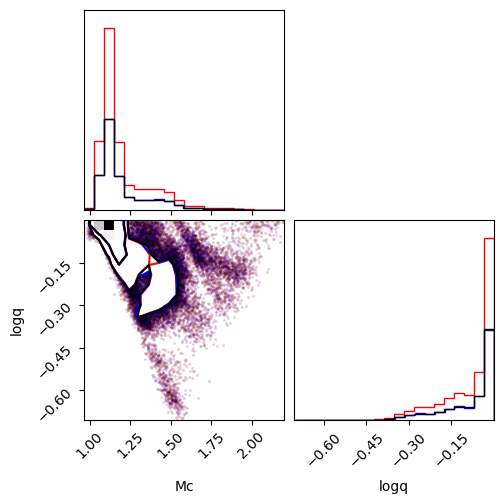

In [9]:
fig = corner.corner(np.array([Mcinj_100000, logqinj_100000]).T, 
                    labels=['Mc', 'logq', 'z'], color='red')
fig = corner.corner(np.array([Mcinj_100000[ns:], logqinj_100000[ns:]]).T, 
                    fig=fig, color='blue')
fig = corner.corner(np.array([Mcinj_100000[:ns], logqinj_100000[:ns]]).T, 
                    fig=fig, color='black')

# Fit the KDE by GMM

In [10]:
ncs = []
scores = []
means = []
covs =[]
weights = []

for nc in tqdm(range(1,20)):
    ncs.append(nc)
    
    gmm = GaussianMixture(nc)
    gm = gmm.fit(np.array([Mcinj_100000[ns:], logqinj_100000[ns:]]).T)
    scores.append(gm.score(np.array([Mcinj_100000[:ns], logqinj_100000[:ns]]).T))
    
    means.append(gm.means_)
    covs.append(gm.covariances_)
    weights.append(gm.weights_)

100%|██████████| 19/19 [00:13<00:00,  1.46it/s]


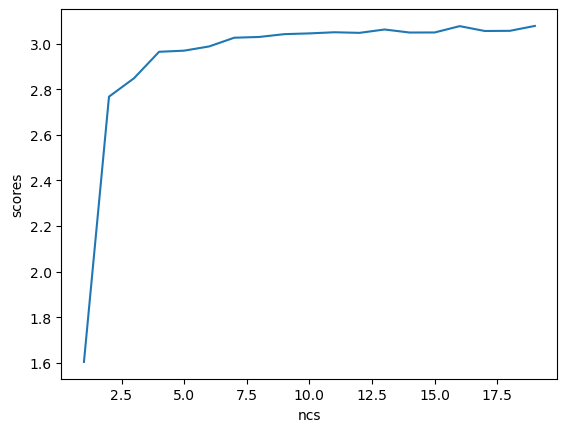

In [11]:
plt.plot(ncs, scores)
plt.xlabel('ncs')
plt.ylabel('scores');

In [12]:
i = np.argmax(scores)
print(ncs[i], means[i].shape, covs[i].shape, weights[i].shape)

19 (19, 2) (19, 2, 2) (19,)


In [13]:
with h5py.File("gmm_mass.h5", "w") as file:
    file.create_dataset('nc_m', data=ncs[i])
    file.create_dataset('mean_m', data=means[i])
    file.create_dataset('cov_m', data=covs[i])
    file.create_dataset('weight_m', data=weights[i])
    file.create_dataset('Mcinj', data=Mcinj_100000)
    file.create_dataset('logqinj', data=logqinj_100000)
file.close()

# Check GMM

### With Samples

In [14]:
nc = ncs[i]
mean = means[i]
cov = covs[i]
weight = weights[i]

In [15]:
gmm = GaussianMixture(nc)
gm = gmm.fit(np.array([Mcinj_100000[ns:], logqinj_100000[ns:]]).T)
gm_samp, _ = gm.sample(50000)
Mcinj_gm, logqinj_gm = gm_samp.T

mask1 = logqinj_gm>0
logqinj_gm[mask1] = -logqinj_gm[mask1]

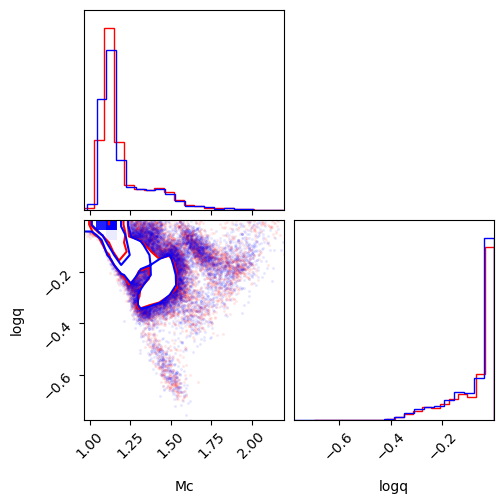

In [16]:
fig = corner.corner(np.array([Mcinj_100000[ns:], logqinj_100000[ns:]]).T, 
                    labels=['Mc','logq'], color='red')
fig = corner.corner(np.array([Mcinj_gm, logqinj_gm]).T, fig=fig, color='blue')